In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Exercise 1

In [2]:
#=============================================================
#Reading in the data
#=============================================================
X = pd.read_csv("C://Users//ayush//OneDrive//Desktop//MSBA//Innovation Challenge//Datasets//archive//KIMORE_DATASET//Kimore ex1//Train_X.csv", header = None)
Y = pd.read_csv("C://Users//ayush//OneDrive//Desktop//MSBA//Innovation Challenge//Datasets//archive//KIMORE_DATASET//Kimore ex1//Train_Y.csv", header = None)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (47300, 100)
Y shape: (473, 1)


In [3]:
#=============================================================
#Programmatically inferring the sequence structure 
#=============================================================

n_samples = Y.shape[0]
n_rows, n_features = X.shape

if n_rows % n_samples != 0:
    raise ValueError("X rows are not divisible by number of labels")

n_frames = n_rows // n_samples

print(f"Inferred structure:")
print(f"  samples  = {n_samples}")
print(f"  frames   = {n_frames}")
print(f"  features = {n_features}")

Inferred structure:
  samples  = 473
  frames   = 100
  features = 100


In [4]:
#=============================================================
#Reshaping into sequence tensor
#=============================================================

X_np = X.to_numpy(dtype=np.float32)
Y_np = Y.to_numpy(dtype=np.float32).reshape(-1)

X_seq = X_np.reshape(n_samples, n_frames, n_features)

print("X_seq:", X_seq.shape)
print("y:", Y_np.shape)

X_seq: (473, 100, 100)
y: (473,)


In [5]:
#=============================================================
#Dropping the tracking state (as it just introduces noise of explicitly tracked v/s inferred)
#=============================================================

xyz_mask = [(i % 4) != 3 for i in range(n_features)]
X_seq = X_seq[:, :, xyz_mask]

print("After dropping tracking state:")
print("X_seq:", X_seq.shape)

After dropping tracking state:
X_seq: (473, 100, 75)


In [6]:
#=============================================================
#Train/Test Split
#=============================================================

X_tr, X_va, y_tr, y_va = train_test_split(
    X_seq,
    Y_np,
    test_size = 0.2,
    random_state = 42
)

print("Train:", X_tr.shape, y_tr.shape)
print("Val:  ", X_va.shape, y_va.shape)

Train: (378, 100, 75) (378,)
Val:   (95, 100, 75) (95,)


In [7]:
#=============================================================
#Feature scaling
#=============================================================

scaler = StandardScaler()

# flatten time dimension
X_tr_2d = X_tr.reshape(-1, X_tr.shape[-1])
X_va_2d = X_va.reshape(-1, X_va.shape[-1])

X_tr_scaled = scaler.fit_transform(X_tr_2d).reshape(X_tr.shape)
X_va_scaled = scaler.transform(X_va_2d).reshape(X_va.shape)

In [8]:
#=============================================================
#Target scaling
#=============================================================

y_mean = y_tr.mean()
y_std  = y_tr.std()

y_tr_z = (y_tr - y_mean) / y_std
y_va_z = (y_va - y_mean) / y_std

In [9]:
#=============================================================
#Building a baseline ML model (CNN regressor)
#=============================================================

tf.random.set_seed(42)

model = Sequential([
    Conv1D(128, kernel_size=5, padding="same", activation="relu",
           input_shape=(n_frames, X_tr_scaled.shape[-1])),
    BatchNormalization(),

    Conv1D(128, kernel_size=5, padding="same", activation="relu"),
    BatchNormalization(),

    Conv1D(64, kernel_size=3, padding="same", activation="relu"),

    GlobalAveragePooling1D(),

    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.Huber(delta=1.0),
    metrics=["mae"]
)

model.summary()

C:\Users\ayush\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 100, 128)            │          48,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 100, 128)            │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 100, 64)             │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,065 (625.25 KB)

 Trainable params: 159,553 (623.25 KB)

 Non-trainable params: 512 (2.00 KB)

In [10]:
#=============================================================
#Training
#=============================================================

callbacks = [
    EarlyStopping(patience=12, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5)
]

history = model.fit(
    X_tr_scaled, y_tr_z,
    validation_data = (X_va_scaled, y_va_z),
    epochs = 200,
    batch_size = 32,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.4358 - mae: 0.7897 - val_loss: 0.3097 - val_mae: 0.6887 - learning_rate: 0.0010
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2919 - mae: 0.6231 - val_loss: 0.2327 - val_mae: 0.5691 - learning_rate: 0.0010
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2377 - mae: 0.5454 - val_loss: 0.2152 - val_mae: 0.5438 - learning_rate: 0.0010
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1992 - mae: 0.4896 - val_loss: 0.2471 - val_mae: 0.6004 - learning_rate: 0.0010
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1539 - mae: 0.4130 - val_loss: 0.2253 - val_mae: 0.5689 - learning_rate: 0.0010
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1245 - mae: 0.3788 - val_loss: 0.1942 - val_mae: 0.5088 - learning_rate: 0.0010
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1241 - mae: 0.3811 - val_loss: 0.2097 - val_mae: 0.5189 - learning_rate: 0.0010
Epoch 

In [11]:
#=============================================================
#Model Evaluation After Re-Converting scaled Y to Original Y
#=============================================================

# Predict on validation set (z-scored space)
y_pred_z = model.predict(X_va_scaled).reshape(-1)

# Convert predictions back to original units
y_pred = y_pred_z * y_std + y_mean

# Compute MAE in original units
mae_orig = mean_absolute_error(y_va, y_pred)

print(f"Validation MAE (original units): {mae_orig:.3f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Validation MAE (original units): 1.121


In [12]:
mae = mean_absolute_error(y_va, y_pred)
rmse = np.sqrt(mean_squared_error(y_va, y_pred))

print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

MAE:  1.121
RMSE: 2.178


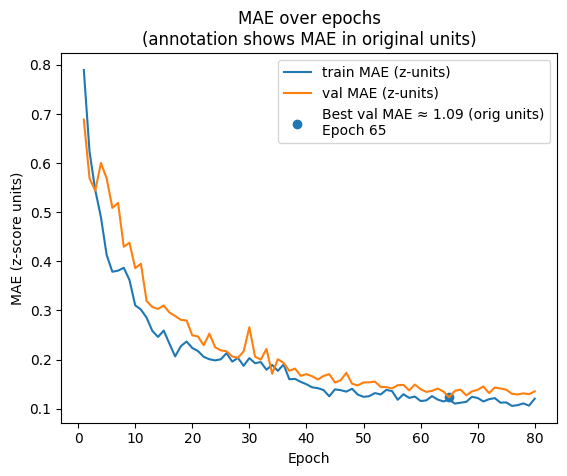

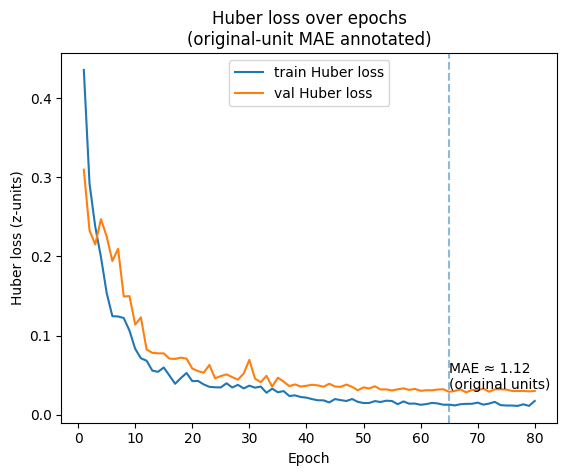

In [13]:
#=============================================================
#Plotting loss curves
#=============================================================

hist = history.history
epochs = np.arange(1, len(hist["val_mae"]) + 1)

#Finding the best epoch based on validation MAE (z-units)
best_epoch = int(np.argmin(hist["val_mae"])) + 1
best_val_mae_z = np.min(hist["val_mae"])

#Converting that MAE to original units
best_val_mae_orig = best_val_mae_z * y_std

plt.figure()
plt.plot(epochs, hist["mae"], label="train MAE (z-units)")
plt.plot(epochs, hist["val_mae"], label="val MAE (z-units)")

plt.scatter(
    [best_epoch],
    [best_val_mae_z],
    label=f"Best val MAE ≈ {best_val_mae_orig:.2f} (orig units)\nEpoch {best_epoch}"
)

plt.title("MAE over epochs\n(annotation shows MAE in original units)")
plt.xlabel("Epoch")
plt.ylabel("MAE (z-score units)")
plt.legend()
plt.show()


#===================================================================================================
best_epoch_loss = int(np.argmin(hist["val_loss"])) + 1

plt.figure()
plt.plot(epochs, hist["loss"], label="train Huber loss")
plt.plot(epochs, hist["val_loss"], label="val Huber loss")

plt.axvline(best_epoch, linestyle="--", alpha=0.5)
plt.text(
    best_epoch,
    np.min(hist["val_loss"]),
    f"MAE ≈ {mae_orig:.2f}\n(original units)",
    verticalalignment="bottom"
)

plt.title("Huber loss over epochs\n(original-unit MAE annotated)")
plt.xlabel("Epoch")
plt.ylabel("Huber loss (z-units)")
plt.legend()
plt.show()

# Exercise 2

In [14]:
#=============================================================
#Reading in the data
#=============================================================
X = pd.read_csv("C://Users//ayush//OneDrive//Desktop//MSBA//Innovation Challenge//Datasets//archive//KIMORE_DATASET//Kimore ex2//Train_X.csv", header = None)
Y = pd.read_csv("C://Users//ayush//OneDrive//Desktop//MSBA//Innovation Challenge//Datasets//archive//KIMORE_DATASET//Kimore ex2//Train_Y.csv", header = None)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (53000, 100)
Y shape: (530, 1)


In [15]:
#=============================================================
#Programmatically inferring the sequence structure 
#=============================================================

n_samples = Y.shape[0]
n_rows, n_features = X.shape

if n_rows % n_samples != 0:
    raise ValueError("X rows are not divisible by number of labels")

n_frames = n_rows // n_samples

print(f"Inferred structure:")
print(f"  samples  = {n_samples}")
print(f"  frames   = {n_frames}")
print(f"  features = {n_features}")

Inferred structure:
  samples  = 530
  frames   = 100
  features = 100


In [16]:
#=============================================================
#Reshaping into sequence tensor
#=============================================================

X_np = X.to_numpy(dtype=np.float32)
Y_np = Y.to_numpy(dtype=np.float32).reshape(-1)

X_seq = X_np.reshape(n_samples, n_frames, n_features)

print("X_seq:", X_seq.shape)
print("y:", Y_np.shape)

X_seq: (530, 100, 100)
y: (530,)


In [17]:
#=============================================================
#Dropping the tracking state (as it just introduces noise of explicitly tracked v/s inferred)
#=============================================================

xyz_mask = [(i % 4) != 3 for i in range(n_features)]
X_seq = X_seq[:, :, xyz_mask]

print("After dropping tracking state:")
print("X_seq:", X_seq.shape)

After dropping tracking state:
X_seq: (530, 100, 75)


In [18]:
#=============================================================
#Train/Test Split
#=============================================================

X_tr, X_va, y_tr, y_va = train_test_split(
    X_seq,
    Y_np,
    test_size = 0.2,
    random_state = 42
)

print("Train:", X_tr.shape, y_tr.shape)
print("Val:  ", X_va.shape, y_va.shape)

Train: (424, 100, 75) (424,)
Val:   (106, 100, 75) (106,)


In [19]:
#=============================================================
#Feature scaling
#=============================================================

scaler = StandardScaler()

# flatten time dimension
X_tr_2d = X_tr.reshape(-1, X_tr.shape[-1])
X_va_2d = X_va.reshape(-1, X_va.shape[-1])

X_tr_scaled = scaler.fit_transform(X_tr_2d).reshape(X_tr.shape)
X_va_scaled = scaler.transform(X_va_2d).reshape(X_va.shape)

In [20]:
#=============================================================
#Target scaling
#=============================================================

y_mean = y_tr.mean()
y_std  = y_tr.std()

y_tr_z = (y_tr - y_mean) / y_std
y_va_z = (y_va - y_mean) / y_std

In [21]:
#=============================================================
#Building a baseline ML model (CNN regressor)
#=============================================================

tf.random.set_seed(42)

model = Sequential([
    Conv1D(128, kernel_size=5, padding="same", activation="relu",
           input_shape=(n_frames, X_tr_scaled.shape[-1])),
    BatchNormalization(),

    Conv1D(128, kernel_size=5, padding="same", activation="relu"),
    BatchNormalization(),

    Conv1D(64, kernel_size=3, padding="same", activation="relu"),

    GlobalAveragePooling1D(),

    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.Huber(delta=1.0),
    metrics=["mae"]
)

model.summary()

C:\Users\ayush\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 100, 128)            │          48,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 100, 128)            │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 100, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 100, 64)             │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,065 (625.25 KB)

 Trainable params: 159,553 (623.25 KB)

 Non-trainable params: 512 (2.00 KB)

In [22]:
#=============================================================
#Training
#=============================================================

callbacks = [
    EarlyStopping(patience=12, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5)
]

history = model.fit(
    X_tr_scaled, y_tr_z,
    validation_data = (X_va_scaled, y_va_z),
    epochs = 200,
    batch_size = 32,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.4252 - mae: 0.7935 - val_loss: 0.3591 - val_mae: 0.7588 - learning_rate: 0.0010
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3446 - mae: 0.7002 - val_loss: 0.3274 - val_mae: 0.7215 - learning_rate: 0.0010
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2676 - mae: 0.5893 - val_loss: 0.3052 - val_mae: 0.7044 - learning_rate: 0.0010
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2275 - mae: 0.5480 - val_loss: 0.3265 - val_mae: 0.7205 - learning_rate: 0.0010
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2128 - mae: 0.5213 - val_loss: 0.2912 - val_mae: 0.6835 - learning_rate: 0.0010
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2075 - mae: 0.5146 - val_loss: 0.3084 - val_mae: 0.6945 - learning_rate: 0.0010
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1779 - mae: 0.4748 - val_loss: 0.2448 - val_mae: 0.6192 - learning_rate: 0.0010
Epoch 

In [23]:
#=============================================================
#Model Evaluation After Re-Converting scaled Y to Original Y
#=============================================================

# Predict on validation set (z-scored space)
y_pred_z = model.predict(X_va_scaled).reshape(-1)

# Convert predictions back to original units
y_pred = y_pred_z * y_std + y_mean

# Compute MAE in original units
mae_orig = mean_absolute_error(y_va, y_pred)

print(f"Validation MAE (original units): {mae_orig:.3f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Validation MAE (original units): 1.993


In [24]:
mae = mean_absolute_error(y_va, y_pred)
rmse = np.sqrt(mean_squared_error(y_va, y_pred))

print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

MAE:  1.993
RMSE: 2.777


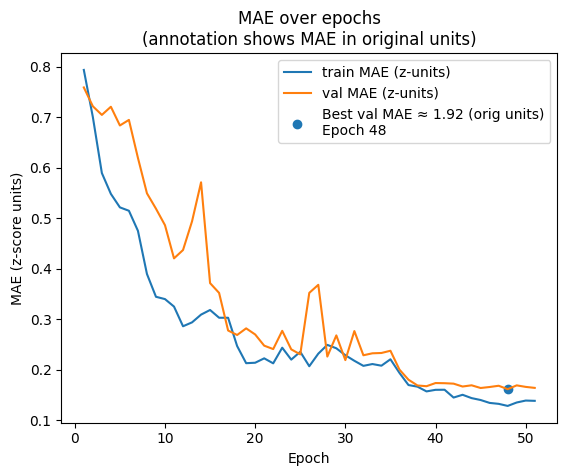

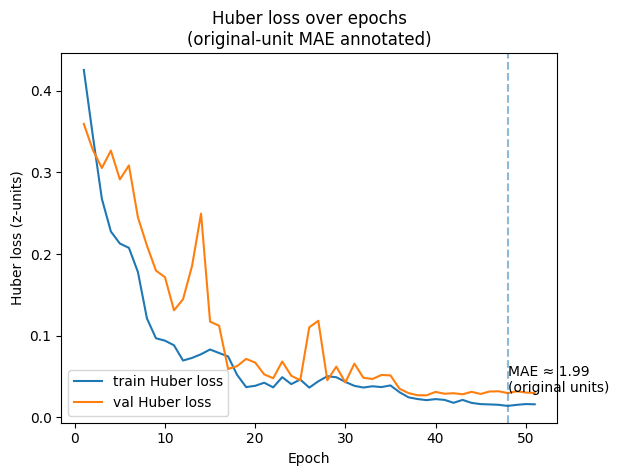

In [25]:
#=============================================================
#Plotting loss curves
#=============================================================

hist = history.history
epochs = np.arange(1, len(hist["val_mae"]) + 1)

#Finding the best epoch based on validation MAE (z-units)
best_epoch = int(np.argmin(hist["val_mae"])) + 1
best_val_mae_z = np.min(hist["val_mae"])

#Converting that MAE to original units
best_val_mae_orig = best_val_mae_z * y_std

plt.figure()
plt.plot(epochs, hist["mae"], label="train MAE (z-units)")
plt.plot(epochs, hist["val_mae"], label="val MAE (z-units)")

plt.scatter(
    [best_epoch],
    [best_val_mae_z],
    label=f"Best val MAE ≈ {best_val_mae_orig:.2f} (orig units)\nEpoch {best_epoch}"
)

plt.title("MAE over epochs\n(annotation shows MAE in original units)")
plt.xlabel("Epoch")
plt.ylabel("MAE (z-score units)")
plt.legend()
plt.show()


#===================================================================================================
best_epoch_loss = int(np.argmin(hist["val_loss"])) + 1

plt.figure()
plt.plot(epochs, hist["loss"], label="train Huber loss")
plt.plot(epochs, hist["val_loss"], label="val Huber loss")

plt.axvline(best_epoch, linestyle="--", alpha=0.5)
plt.text(
    best_epoch,
    np.min(hist["val_loss"]),
    f"MAE ≈ {mae_orig:.2f}\n(original units)",
    verticalalignment="bottom"
)

plt.title("Huber loss over epochs\n(original-unit MAE annotated)")
plt.xlabel("Epoch")
plt.ylabel("Huber loss (z-units)")
plt.legend()
plt.show()

# Exercise 3

In [26]:
#=============================================================
#Reading in the data
#=============================================================
X = pd.read_csv("C://Users//ayush//OneDrive//Desktop//MSBA//Innovation Challenge//Datasets//archive//KIMORE_DATASET//Kimore ex3//Train_X.csv", header = None)
Y = pd.read_csv("C://Users//ayush//OneDrive//Desktop//MSBA//Innovation Challenge//Datasets//archive//KIMORE_DATASET//Kimore ex3//Train_Y.csv", header = None)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (57600, 100)
Y shape: (576, 1)


In [27]:
#=============================================================
#Programmatically inferring the sequence structure 
#=============================================================

n_samples = Y.shape[0]
n_rows, n_features = X.shape

if n_rows % n_samples != 0:
    raise ValueError("X rows are not divisible by number of labels")

n_frames = n_rows // n_samples

print(f"Inferred structure:")
print(f"  samples  = {n_samples}")
print(f"  frames   = {n_frames}")
print(f"  features = {n_features}")

Inferred structure:
  samples  = 576
  frames   = 100
  features = 100


In [28]:
#=============================================================
#Reshaping into sequence tensor
#=============================================================

X_np = X.to_numpy(dtype=np.float32)
Y_np = Y.to_numpy(dtype=np.float32).reshape(-1)

X_seq = X_np.reshape(n_samples, n_frames, n_features)

print("X_seq:", X_seq.shape)
print("y:", Y_np.shape)

X_seq: (576, 100, 100)
y: (576,)


In [29]:
#=============================================================
#Dropping the tracking state (as it just introduces noise of explicitly tracked v/s inferred)
#=============================================================

xyz_mask = [(i % 4) != 3 for i in range(n_features)]
X_seq = X_seq[:, :, xyz_mask]

print("After dropping tracking state:")
print("X_seq:", X_seq.shape)

After dropping tracking state:
X_seq: (576, 100, 75)


In [30]:
#=============================================================
#Train/Test Split
#=============================================================

X_tr, X_va, y_tr, y_va = train_test_split(
    X_seq,
    Y_np,
    test_size = 0.2,
    random_state = 42
)

print("Train:", X_tr.shape, y_tr.shape)
print("Val:  ", X_va.shape, y_va.shape)

Train: (460, 100, 75) (460,)
Val:   (116, 100, 75) (116,)


In [31]:
#=============================================================
#Feature scaling
#=============================================================

scaler = StandardScaler()

# flatten time dimension
X_tr_2d = X_tr.reshape(-1, X_tr.shape[-1])
X_va_2d = X_va.reshape(-1, X_va.shape[-1])

X_tr_scaled = scaler.fit_transform(X_tr_2d).reshape(X_tr.shape)
X_va_scaled = scaler.transform(X_va_2d).reshape(X_va.shape)

In [32]:
#=============================================================
#Target scaling
#=============================================================

y_mean = y_tr.mean()
y_std  = y_tr.std()

y_tr_z = (y_tr - y_mean) / y_std
y_va_z = (y_va - y_mean) / y_std

In [33]:
#=============================================================
#Building a baseline ML model (CNN regressor)
#=============================================================

tf.random.set_seed(42)

model = Sequential([
    Conv1D(128, kernel_size=5, padding="same", activation="relu",
           input_shape=(n_frames, X_tr_scaled.shape[-1])),
    BatchNormalization(),

    Conv1D(128, kernel_size=5, padding="same", activation="relu"),
    BatchNormalization(),

    Conv1D(64, kernel_size=3, padding="same", activation="relu"),

    GlobalAveragePooling1D(),

    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.Huber(delta=1.0),
    metrics=["mae"]
)

model.summary()

C:\Users\ayush\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 100, 128)            │          48,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 100, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 100, 128)            │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 100, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 100, 64)             │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,065 (625.25 KB)

 Trainable params: 159,553 (623.25 KB)

 Non-trainable params: 512 (2.00 KB)

In [34]:
#=============================================================
#Training
#=============================================================

callbacks = [
    EarlyStopping(patience=12, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5)
]

history = model.fit(
    X_tr_scaled, y_tr_z,
    validation_data = (X_va_scaled, y_va_z),
    epochs = 200,
    batch_size = 32,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.4431 - mae: 0.8118 - val_loss: 0.3903 - val_mae: 0.7672 - learning_rate: 0.0010
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2907 - mae: 0.6124 - val_loss: 0.4221 - val_mae: 0.7957 - learning_rate: 0.0010
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2739 - mae: 0.5867 - val_loss: 0.3394 - val_mae: 0.7102 - learning_rate: 0.0010
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2351 - mae: 0.5374 - val_loss: 0.3766 - val_mae: 0.7501 - learning_rate: 0.0010
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1899 - mae: 0.4757 - val_loss: 0.2686 - val_mae: 0.6119 - learning_rate: 0.0010
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1771 - mae: 0.4518 - val_loss: 0.2841 - val_mae: 0.6289 - learning_rate: 0.0010
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1660 - mae: 0.4270 - val_loss: 0.1977 - val_mae: 0.4963 - learning_rate: 0.0010
Epoch 

In [35]:
#=============================================================
#Model Evaluation After Re-Converting scaled Y to Original Y
#=============================================================

# Predict on validation set (z-scored space)
y_pred_z = model.predict(X_va_scaled).reshape(-1)

# Convert predictions back to original units
y_pred = y_pred_z * y_std + y_mean

# Compute MAE in original units
mae_orig = mean_absolute_error(y_va, y_pred)

print(f"Validation MAE (original units): {mae_orig:.3f}")

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/stepWARNING:tensorflow:6 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000245905A7B00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Validation MAE (original units): 1.474


In [36]:
mae = mean_absolute_error(y_va, y_pred)
rmse = np.sqrt(mean_squared_error(y_va, y_pred))

print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

MAE:  1.474
RMSE: 2.005


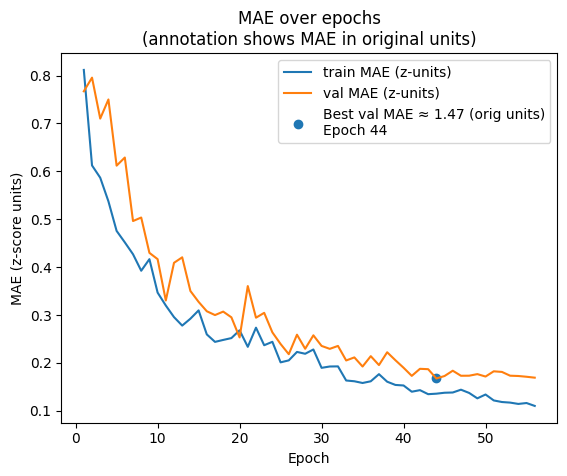

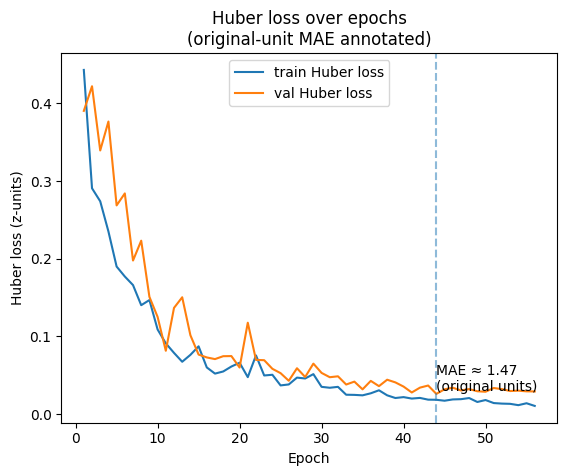

In [37]:
#=============================================================
#Plotting loss curves
#=============================================================

hist = history.history
epochs = np.arange(1, len(hist["val_mae"]) + 1)

#Finding the best epoch based on validation MAE (z-units)
best_epoch = int(np.argmin(hist["val_mae"])) + 1
best_val_mae_z = np.min(hist["val_mae"])

#Converting that MAE to original units
best_val_mae_orig = best_val_mae_z * y_std

plt.figure()
plt.plot(epochs, hist["mae"], label="train MAE (z-units)")
plt.plot(epochs, hist["val_mae"], label="val MAE (z-units)")

plt.scatter(
    [best_epoch],
    [best_val_mae_z],
    label=f"Best val MAE ≈ {best_val_mae_orig:.2f} (orig units)\nEpoch {best_epoch}"
)

plt.title("MAE over epochs\n(annotation shows MAE in original units)")
plt.xlabel("Epoch")
plt.ylabel("MAE (z-score units)")
plt.legend()
plt.show()


#===================================================================================================
best_epoch_loss = int(np.argmin(hist["val_loss"])) + 1

plt.figure()
plt.plot(epochs, hist["loss"], label="train Huber loss")
plt.plot(epochs, hist["val_loss"], label="val Huber loss")

plt.axvline(best_epoch, linestyle="--", alpha=0.5)
plt.text(
    best_epoch,
    np.min(hist["val_loss"]),
    f"MAE ≈ {mae_orig:.2f}\n(original units)",
    verticalalignment="bottom"
)

plt.title("Huber loss over epochs\n(original-unit MAE annotated)")
plt.xlabel("Epoch")
plt.ylabel("Huber loss (z-units)")
plt.legend()
plt.show()

# Exercise 4

In [38]:
#=============================================================
#Reading in the data
#=============================================================
X = pd.read_csv("C://Users//ayush//OneDrive//Desktop//MSBA//Innovation Challenge//Datasets//archive//KIMORE_DATASET//Kimore ex4//Train_X.csv", header = None)
Y = pd.read_csv("C://Users//ayush//OneDrive//Desktop//MSBA//Innovation Challenge//Datasets//archive//KIMORE_DATASET//Kimore ex4//Train_Y.csv", header = None)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (56900, 100)
Y shape: (569, 1)


In [39]:
#=============================================================
#Programmatically inferring the sequence structure 
#=============================================================

n_samples = Y.shape[0]
n_rows, n_features = X.shape

if n_rows % n_samples != 0:
    raise ValueError("X rows are not divisible by number of labels")

n_frames = n_rows // n_samples

print(f"Inferred structure:")
print(f"  samples  = {n_samples}")
print(f"  frames   = {n_frames}")
print(f"  features = {n_features}")

Inferred structure:
  samples  = 569
  frames   = 100
  features = 100


In [40]:
#=============================================================
#Reshaping into sequence tensor
#=============================================================

X_np = X.to_numpy(dtype=np.float32)
Y_np = Y.to_numpy(dtype=np.float32).reshape(-1)

X_seq = X_np.reshape(n_samples, n_frames, n_features)

print("X_seq:", X_seq.shape)
print("y:", Y_np.shape)

X_seq: (569, 100, 100)
y: (569,)


In [41]:
#=============================================================
#Dropping the tracking state (as it just introduces noise of explicitly tracked v/s inferred)
#=============================================================

xyz_mask = [(i % 4) != 3 for i in range(n_features)]
X_seq = X_seq[:, :, xyz_mask]

print("After dropping tracking state:")
print("X_seq:", X_seq.shape)

After dropping tracking state:
X_seq: (569, 100, 75)


In [42]:
#=============================================================
#Train/Test Split
#=============================================================

X_tr, X_va, y_tr, y_va = train_test_split(
    X_seq,
    Y_np,
    test_size = 0.2,
    random_state = 42
)

print("Train:", X_tr.shape, y_tr.shape)
print("Val:  ", X_va.shape, y_va.shape)

Train: (455, 100, 75) (455,)
Val:   (114, 100, 75) (114,)


In [43]:
#=============================================================
#Feature scaling
#=============================================================

scaler = StandardScaler()

# flatten time dimension
X_tr_2d = X_tr.reshape(-1, X_tr.shape[-1])
X_va_2d = X_va.reshape(-1, X_va.shape[-1])

X_tr_scaled = scaler.fit_transform(X_tr_2d).reshape(X_tr.shape)
X_va_scaled = scaler.transform(X_va_2d).reshape(X_va.shape)

In [44]:
#=============================================================
#Target scaling
#=============================================================

y_mean = y_tr.mean()
y_std  = y_tr.std()

y_tr_z = (y_tr - y_mean) / y_std
y_va_z = (y_va - y_mean) / y_std

In [45]:
#=============================================================
#Building a baseline ML model (CNN regressor)
#=============================================================

tf.random.set_seed(42)

model = Sequential([
    Conv1D(128, kernel_size=5, padding="same", activation="relu",
           input_shape=(n_frames, X_tr_scaled.shape[-1])),
    BatchNormalization(),

    Conv1D(128, kernel_size=5, padding="same", activation="relu"),
    BatchNormalization(),

    Conv1D(64, kernel_size=3, padding="same", activation="relu"),

    GlobalAveragePooling1D(),

    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.Huber(delta=1.0),
    metrics=["mae"]
)

model.summary()

C:\Users\ayush\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)                    │ (None, 100, 128)            │          48,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 100, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 100, 128)            │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 100, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 100, 64)             │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,065 (625.25 KB)

 Trainable params: 159,553 (623.25 KB)

 Non-trainable params: 512 (2.00 KB)

In [46]:
#=============================================================
#Training
#=============================================================

callbacks = [
    EarlyStopping(patience=12, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5)
]

history = model.fit(
    X_tr_scaled, y_tr_z,
    validation_data = (X_va_scaled, y_va_z),
    epochs = 200,
    batch_size = 32,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.4040 - mae: 0.7681 - val_loss: 0.3021 - val_mae: 0.6985 - learning_rate: 0.0010
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2681 - mae: 0.6013 - val_loss: 0.3729 - val_mae: 0.7597 - learning_rate: 0.0010
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2132 - mae: 0.5185 - val_loss: 0.3482 - val_mae: 0.7457 - learning_rate: 0.0010
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1536 - mae: 0.4381 - val_loss: 0.3570 - val_mae: 0.7354 - learning_rate: 0.0010
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1151 - mae: 0.3718 - val_loss: 0.2463 - val_mae: 0.6166 - learning_rate: 0.0010
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1149 - mae: 0.3802 - val_loss: 0.2575 - val_mae: 0.6181 - learning_rate: 0.0010
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0911 - mae: 0.3281 - val_loss: 0.2151 - val_mae: 0.5498 - learning_rate: 0.0010
Epoch 

In [47]:
#=============================================================
#Model Evaluation After Re-Converting scaled Y to Original Y
#=============================================================

# Predict on validation set (z-scored space)
y_pred_z = model.predict(X_va_scaled).reshape(-1)

# Convert predictions back to original units
y_pred = y_pred_z * y_std + y_mean

# Compute MAE in original units
mae_orig = mean_absolute_error(y_va, y_pred)

print(f"Validation MAE (original units): {mae_orig:.3f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Validation MAE (original units): 1.114


In [48]:
mae = mean_absolute_error(y_va, y_pred)
rmse = np.sqrt(mean_squared_error(y_va, y_pred))

print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

MAE:  1.114
RMSE: 1.525


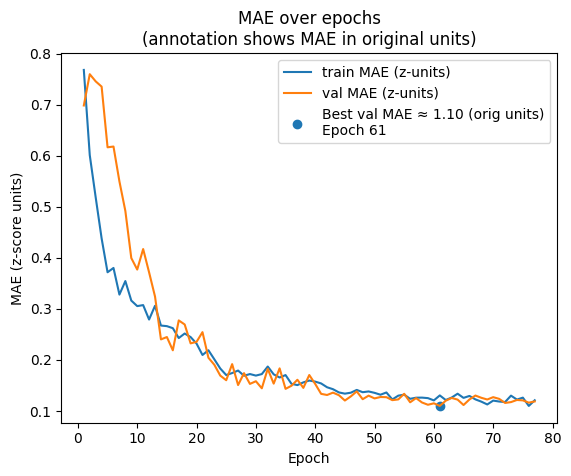

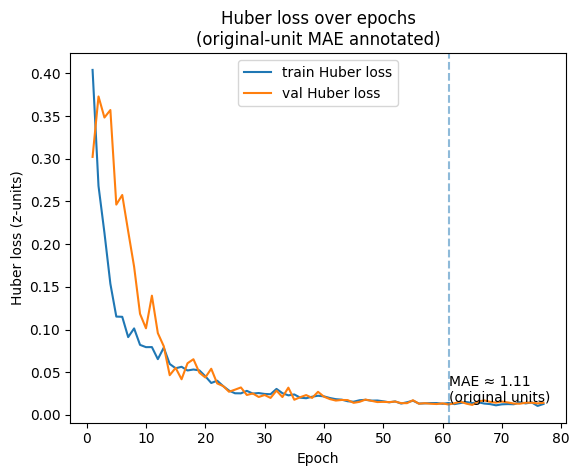

In [49]:
#=============================================================
#Plotting loss curves
#=============================================================

hist = history.history
epochs = np.arange(1, len(hist["val_mae"]) + 1)

#Finding the best epoch based on validation MAE (z-units)
best_epoch = int(np.argmin(hist["val_mae"])) + 1
best_val_mae_z = np.min(hist["val_mae"])

#Converting that MAE to original units
best_val_mae_orig = best_val_mae_z * y_std

plt.figure()
plt.plot(epochs, hist["mae"], label="train MAE (z-units)")
plt.plot(epochs, hist["val_mae"], label="val MAE (z-units)")

plt.scatter(
    [best_epoch],
    [best_val_mae_z],
    label=f"Best val MAE ≈ {best_val_mae_orig:.2f} (orig units)\nEpoch {best_epoch}"
)

plt.title("MAE over epochs\n(annotation shows MAE in original units)")
plt.xlabel("Epoch")
plt.ylabel("MAE (z-score units)")
plt.legend()
plt.show()


#===================================================================================================
best_epoch_loss = int(np.argmin(hist["val_loss"])) + 1

plt.figure()
plt.plot(epochs, hist["loss"], label="train Huber loss")
plt.plot(epochs, hist["val_loss"], label="val Huber loss")

plt.axvline(best_epoch, linestyle="--", alpha=0.5)
plt.text(
    best_epoch,
    np.min(hist["val_loss"]),
    f"MAE ≈ {mae_orig:.2f}\n(original units)",
    verticalalignment="bottom"
)

plt.title("Huber loss over epochs\n(original-unit MAE annotated)")
plt.xlabel("Epoch")
plt.ylabel("Huber loss (z-units)")
plt.legend()
plt.show()

# Exercise 5

In [50]:
#=============================================================
#Reading in the data
#=============================================================
X = pd.read_csv("C://Users//ayush//OneDrive//Desktop//MSBA//Innovation Challenge//Datasets//archive//KIMORE_DATASET//Kimore ex5//Train_X.csv", header = None)
Y = pd.read_csv("C://Users//ayush//OneDrive//Desktop//MSBA//Innovation Challenge//Datasets//archive//KIMORE_DATASET//Kimore ex5//Train_Y.csv", header = None)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (37300, 100)
Y shape: (373, 1)


In [51]:
#=============================================================
#Programmatically inferring the sequence structure 
#=============================================================

n_samples = Y.shape[0]
n_rows, n_features = X.shape

if n_rows % n_samples != 0:
    raise ValueError("X rows are not divisible by number of labels")

n_frames = n_rows // n_samples

print(f"Inferred structure:")
print(f"  samples  = {n_samples}")
print(f"  frames   = {n_frames}")
print(f"  features = {n_features}")

Inferred structure:
  samples  = 373
  frames   = 100
  features = 100


In [52]:
#=============================================================
#Reshaping into sequence tensor
#=============================================================

X_np = X.to_numpy(dtype=np.float32)
Y_np = Y.to_numpy(dtype=np.float32).reshape(-1)

X_seq = X_np.reshape(n_samples, n_frames, n_features)

print("X_seq:", X_seq.shape)
print("y:", Y_np.shape)

X_seq: (373, 100, 100)
y: (373,)


In [53]:
#=============================================================
#Dropping the tracking state (as it just introduces noise of explicitly tracked v/s inferred)
#=============================================================

xyz_mask = [(i % 4) != 3 for i in range(n_features)]
X_seq = X_seq[:, :, xyz_mask]

print("After dropping tracking state:")
print("X_seq:", X_seq.shape)

After dropping tracking state:
X_seq: (373, 100, 75)


In [54]:
#=============================================================
#Train/Test Split
#=============================================================

X_tr, X_va, y_tr, y_va = train_test_split(
    X_seq,
    Y_np,
    test_size = 0.2,
    random_state = 42
)

print("Train:", X_tr.shape, y_tr.shape)
print("Val:  ", X_va.shape, y_va.shape)

Train: (298, 100, 75) (298,)
Val:   (75, 100, 75) (75,)


In [55]:
#=============================================================
#Feature scaling
#=============================================================

scaler = StandardScaler()

# flatten time dimension
X_tr_2d = X_tr.reshape(-1, X_tr.shape[-1])
X_va_2d = X_va.reshape(-1, X_va.shape[-1])

X_tr_scaled = scaler.fit_transform(X_tr_2d).reshape(X_tr.shape)
X_va_scaled = scaler.transform(X_va_2d).reshape(X_va.shape)

In [56]:
#=============================================================
#Target scaling
#=============================================================

y_mean = y_tr.mean()
y_std  = y_tr.std()

y_tr_z = (y_tr - y_mean) / y_std
y_va_z = (y_va - y_mean) / y_std

In [57]:
#=============================================================
#Building a baseline ML model (CNN regressor)
#=============================================================

tf.random.set_seed(42)

model = Sequential([
    Conv1D(128, kernel_size=5, padding="same", activation="relu",
           input_shape=(n_frames, X_tr_scaled.shape[-1])),
    BatchNormalization(),

    Conv1D(128, kernel_size=5, padding="same", activation="relu"),
    BatchNormalization(),

    Conv1D(64, kernel_size=3, padding="same", activation="relu"),

    GlobalAveragePooling1D(),

    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.Huber(delta=1.0),
    metrics=["mae"]
)

model.summary()

C:\Users\ayush\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 100, 128)            │          48,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 100, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 100, 128)            │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 100, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 100, 64)             │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,065 (625.25 KB)

 Trainable params: 159,553 (623.25 KB)

 Non-trainable params: 512 (2.00 KB)

In [58]:
#=============================================================
#Training
#=============================================================

callbacks = [
    EarlyStopping(patience=12, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5)
]

history = model.fit(
    X_tr_scaled, y_tr_z,
    validation_data = (X_va_scaled, y_va_z),
    epochs = 200,
    batch_size = 32,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.3524 - mae: 0.7097 - val_loss: 0.3674 - val_mae: 0.7323 - learning_rate: 0.0010
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2851 - mae: 0.6201 - val_loss: 0.3680 - val_mae: 0.7551 - learning_rate: 0.0010
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1902 - mae: 0.4819 - val_loss: 0.3293 - val_mae: 0.7119 - learning_rate: 0.0010
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1696 - mae: 0.4567 - val_loss: 0.3067 - val_mae: 0.6383 - learning_rate: 0.0010
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1466 - mae: 0.4209 - val_loss: 0.2798 - val_mae: 0.6325 - learning_rate: 0.0010
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1328 - mae: 0.3967 - val_loss: 0.3020 - val_mae: 0.6595 - learning_rate: 0.0010
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1098 - mae: 0.3556 - val_loss: 0.2626 - val_mae: 0.6017 - learning_rate: 0.0010
Epoch 

In [59]:
#=============================================================
#Model Evaluation After Re-Converting scaled Y to Original Y
#=============================================================

# Predict on validation set (z-scored space)
y_pred_z = model.predict(X_va_scaled).reshape(-1)

# Convert predictions back to original units
y_pred = y_pred_z * y_std + y_mean

# Compute MAE in original units
mae_orig = mean_absolute_error(y_va, y_pred)

print(f"Validation MAE (original units): {mae_orig:.3f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Validation MAE (original units): 1.810


In [60]:
mae = mean_absolute_error(y_va, y_pred)
rmse = np.sqrt(mean_squared_error(y_va, y_pred))

print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

MAE:  1.810
RMSE: 2.443


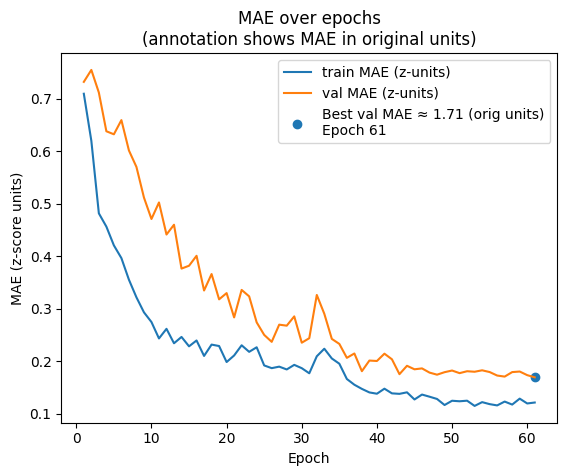

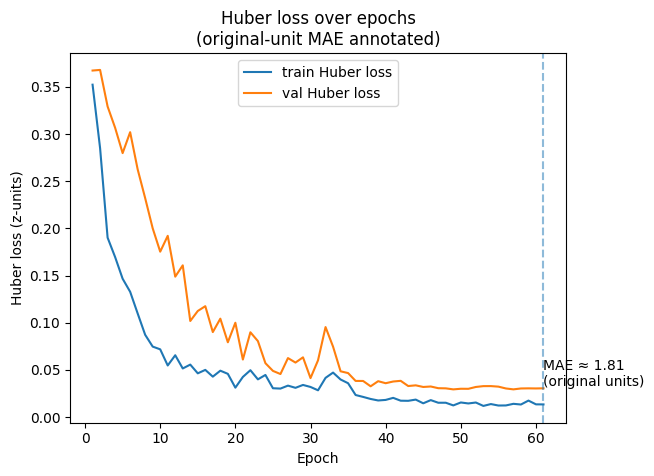

In [61]:
#=============================================================
#Plotting loss curves
#=============================================================

hist = history.history
epochs = np.arange(1, len(hist["val_mae"]) + 1)

#Finding the best epoch based on validation MAE (z-units)
best_epoch = int(np.argmin(hist["val_mae"])) + 1
best_val_mae_z = np.min(hist["val_mae"])

#Converting that MAE to original units
best_val_mae_orig = best_val_mae_z * y_std

plt.figure()
plt.plot(epochs, hist["mae"], label="train MAE (z-units)")
plt.plot(epochs, hist["val_mae"], label="val MAE (z-units)")

plt.scatter(
    [best_epoch],
    [best_val_mae_z],
    label=f"Best val MAE ≈ {best_val_mae_orig:.2f} (orig units)\nEpoch {best_epoch}"
)

plt.title("MAE over epochs\n(annotation shows MAE in original units)")
plt.xlabel("Epoch")
plt.ylabel("MAE (z-score units)")
plt.legend()
plt.show()


#===================================================================================================
best_epoch_loss = int(np.argmin(hist["val_loss"])) + 1

plt.figure()
plt.plot(epochs, hist["loss"], label="train Huber loss")
plt.plot(epochs, hist["val_loss"], label="val Huber loss")

plt.axvline(best_epoch, linestyle="--", alpha=0.5)
plt.text(
    best_epoch,
    np.min(hist["val_loss"]),
    f"MAE ≈ {mae_orig:.2f}\n(original units)",
    verticalalignment="bottom"
)

plt.title("Huber loss over epochs\n(original-unit MAE annotated)")
plt.xlabel("Epoch")
plt.ylabel("Huber loss (z-units)")
plt.legend()
plt.show()

# All Exercises

In [62]:
#=============================================================
#Reading in the data
#=============================================================
X1 = pd.read_csv("C://Users//ayush//OneDrive//Desktop//MSBA//Innovation Challenge//Datasets//archive//KIMORE_DATASET//Kimore ex1//Train_X.csv", header = None)
X2 = pd.read_csv("C://Users//ayush//OneDrive//Desktop//MSBA//Innovation Challenge//Datasets//archive//KIMORE_DATASET//Kimore ex2//Train_X.csv", header = None)
X3 = pd.read_csv("C://Users//ayush//OneDrive//Desktop//MSBA//Innovation Challenge//Datasets//archive//KIMORE_DATASET//Kimore ex3//Train_X.csv", header = None)
X4 = pd.read_csv("C://Users//ayush//OneDrive//Desktop//MSBA//Innovation Challenge//Datasets//archive//KIMORE_DATASET//Kimore ex4//Train_X.csv", header = None)
X5 = pd.read_csv("C://Users//ayush//OneDrive//Desktop//MSBA//Innovation Challenge//Datasets//archive//KIMORE_DATASET//Kimore ex5//Train_X.csv", header = None)
X = pd.concat([X1, X2, X3, X4, X5], ignore_index = True)


Y1 = pd.read_csv("C://Users//ayush//OneDrive//Desktop//MSBA//Innovation Challenge//Datasets//archive//KIMORE_DATASET//Kimore ex1//Train_Y.csv", header = None)
Y2 = pd.read_csv("C://Users//ayush//OneDrive//Desktop//MSBA//Innovation Challenge//Datasets//archive//KIMORE_DATASET//Kimore ex2//Train_Y.csv", header = None)
Y3 = pd.read_csv("C://Users//ayush//OneDrive//Desktop//MSBA//Innovation Challenge//Datasets//archive//KIMORE_DATASET//Kimore ex3//Train_Y.csv", header = None)
Y4 = pd.read_csv("C://Users//ayush//OneDrive//Desktop//MSBA//Innovation Challenge//Datasets//archive//KIMORE_DATASET//Kimore ex4//Train_Y.csv", header = None)
Y5 = pd.read_csv("C://Users//ayush//OneDrive//Desktop//MSBA//Innovation Challenge//Datasets//archive//KIMORE_DATASET//Kimore ex5//Train_Y.csv", header = None)
Y = pd.concat([Y1, Y2, Y3, Y4, Y5], ignore_index = True)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (252100, 100)
Y shape: (2521, 1)


In [63]:
#=============================================================
#Programmatically inferring the sequence structure 
#=============================================================

n_samples = Y.shape[0]
n_rows, n_features = X.shape

if n_rows % n_samples != 0:
    raise ValueError("X rows are not divisible by number of labels")

n_frames = n_rows // n_samples

print(f"Inferred structure:")
print(f"  samples  = {n_samples}")
print(f"  frames   = {n_frames}")
print(f"  features = {n_features}")

Inferred structure:
  samples  = 2521
  frames   = 100
  features = 100


In [64]:
#=============================================================
#Reshaping into sequence tensor
#=============================================================

X_np = X.to_numpy(dtype=np.float32)
Y_np = Y.to_numpy(dtype=np.float32).reshape(-1)

X_seq = X_np.reshape(n_samples, n_frames, n_features)

print("X_seq:", X_seq.shape)
print("y:", Y_np.shape)

X_seq: (2521, 100, 100)
y: (2521,)


In [65]:
#=============================================================
#Dropping the tracking state (as it just introduces noise of explicitly tracked v/s inferred)
#=============================================================

xyz_mask = [(i % 4) != 3 for i in range(n_features)]
X_seq = X_seq[:, :, xyz_mask]

print("After dropping tracking state:")
print("X_seq:", X_seq.shape)

After dropping tracking state:
X_seq: (2521, 100, 75)


In [66]:
#=============================================================
#Train/Test Split
#=============================================================

X_tr, X_va, y_tr, y_va = train_test_split(
    X_seq,
    Y_np,
    test_size = 0.2,
    random_state = 42
)

print("Train:", X_tr.shape, y_tr.shape)
print("Val:  ", X_va.shape, y_va.shape)

Train: (2016, 100, 75) (2016,)
Val:   (505, 100, 75) (505,)


In [67]:
#=============================================================
#Feature scaling
#=============================================================

scaler = StandardScaler()

# flatten time dimension
X_tr_2d = X_tr.reshape(-1, X_tr.shape[-1])
X_va_2d = X_va.reshape(-1, X_va.shape[-1])

X_tr_scaled = scaler.fit_transform(X_tr_2d).reshape(X_tr.shape)
X_va_scaled = scaler.transform(X_va_2d).reshape(X_va.shape)

In [68]:
#=============================================================
#Target scaling
#=============================================================

y_mean = y_tr.mean()
y_std  = y_tr.std()

y_tr_z = (y_tr - y_mean) / y_std
y_va_z = (y_va - y_mean) / y_std

In [69]:
#=============================================================
#Building a baseline ML model (CNN regressor)
#=============================================================

tf.random.set_seed(42)

model = Sequential([
    Conv1D(128, kernel_size=5, padding="same", activation="relu",
           input_shape=(n_frames, X_tr_scaled.shape[-1])),
    BatchNormalization(),

    Conv1D(128, kernel_size=5, padding="same", activation="relu"),
    BatchNormalization(),

    Conv1D(64, kernel_size=3, padding="same", activation="relu"),

    GlobalAveragePooling1D(),

    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.Huber(delta=1.0),
    metrics=["mae"]
)

model.summary()

C:\Users\ayush\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)                   │ (None, 100, 128)            │          48,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 100, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 100, 128)            │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 100, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 100, 64)             │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_5           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,065 (625.25 KB)

 Trainable params: 159,553 (623.25 KB)

 Non-trainable params: 512 (2.00 KB)

In [70]:
#=============================================================
#Training
#=============================================================

callbacks = [
    EarlyStopping(patience=12, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-5)
]

history = model.fit(
    X_tr_scaled, y_tr_z,
    validation_data = (X_va_scaled, y_va_z),
    epochs = 200,
    batch_size = 32,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.3507 - mae: 0.6970 - val_loss: 0.3041 - val_mae: 0.6503 - learning_rate: 0.0010
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2561 - mae: 0.5813 - val_loss: 0.2607 - val_mae: 0.5851 - learning_rate: 0.0010
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2251 - mae: 0.5357 - val_loss: 0.2275 - val_mae: 0.5374 - learning_rate: 0.0010
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1884 - mae: 0.4848 - val_loss: 0.2041 - val_mae: 0.4909 - learning_rate: 0.0010
Epoch 5/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1617 - mae: 0.4404 - val_loss: 0.1755 - val_mae: 0.4519 - learning_rate: 0.0010
Epoch 6/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1424 - mae: 0.4125 - val_loss: 0.1516 - val_mae: 0.4025 - learning_rate: 0.0010
Epoch 7/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1303 - mae: 0.3938 - val_loss: 0.1410 - val_mae: 0.3901 - learning_rate: 0.0010
Epoch 

In [71]:
#=============================================================
#Model Evaluation After Re-Converting scaled Y to Original Y
#=============================================================

# Predict on validation set (z-scored space)
y_pred_z = model.predict(X_va_scaled).reshape(-1)

# Convert predictions back to original units
y_pred = y_pred_z * y_std + y_mean

# Compute MAE in original units
mae_orig = mean_absolute_error(y_va, y_pred)

print(f"Validation MAE (original units): {mae_orig:.3f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Validation MAE (original units): 1.576


In [72]:
mae = mean_absolute_error(y_va, y_pred)
rmse = np.sqrt(mean_squared_error(y_va, y_pred))

print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

MAE:  1.576
RMSE: 2.560


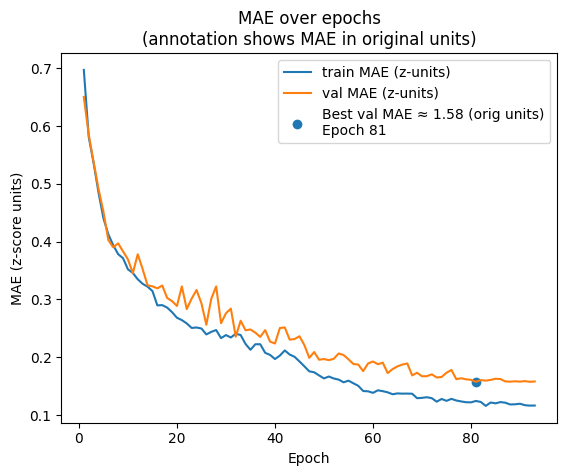

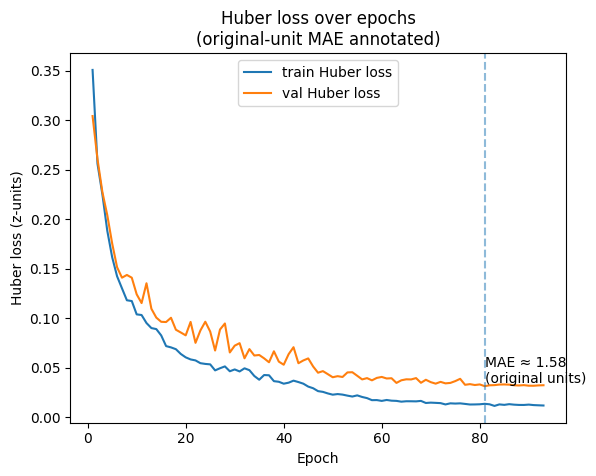

In [73]:
#=============================================================
#Plotting loss curves
#=============================================================

hist = history.history
epochs = np.arange(1, len(hist["val_mae"]) + 1)

#Finding the best epoch based on validation MAE (z-units)
best_epoch = int(np.argmin(hist["val_mae"])) + 1
best_val_mae_z = np.min(hist["val_mae"])

#Converting that MAE to original units
best_val_mae_orig = best_val_mae_z * y_std

plt.figure()
plt.plot(epochs, hist["mae"], label="train MAE (z-units)")
plt.plot(epochs, hist["val_mae"], label="val MAE (z-units)")

plt.scatter(
    [best_epoch],
    [best_val_mae_z],
    label=f"Best val MAE ≈ {best_val_mae_orig:.2f} (orig units)\nEpoch {best_epoch}"
)

plt.title("MAE over epochs\n(annotation shows MAE in original units)")
plt.xlabel("Epoch")
plt.ylabel("MAE (z-score units)")
plt.legend()
plt.show()


#===================================================================================================
best_epoch_loss = int(np.argmin(hist["val_loss"])) + 1

plt.figure()
plt.plot(epochs, hist["loss"], label="train Huber loss")
plt.plot(epochs, hist["val_loss"], label="val Huber loss")

plt.axvline(best_epoch, linestyle="--", alpha=0.5)
plt.text(
    best_epoch,
    np.min(hist["val_loss"]),
    f"MAE ≈ {mae_orig:.2f}\n(original units)",
    verticalalignment="bottom"
)

plt.title("Huber loss over epochs\n(original-unit MAE annotated)")
plt.xlabel("Epoch")
plt.ylabel("Huber loss (z-units)")
plt.legend()
plt.show()